In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py


In [2]:
#Inflate variant effect predictions from h5 file

def inflate_snp_predictions(pos_or_neg, fold_index=[0, 1, 2, 3], fold_suffixes=['', '', '', '']) :

    print("Inflating predictions for '" + pos_or_neg + "'.")
    
    df_folds = []

    #Loop over folds
    for fold_ix, fold_suffix in zip(fold_index, fold_suffixes) :

        #Load file
        sed = h5py.File('test_paqtl/f' + str(fold_ix) + 'c0' + fold_suffix + '/paqtl_pip90/merge_' + pos_or_neg + '/sed.h5', 'r')
        
        gene_id_mat = sed['gene'][()]
        snp_mat = sed['snp'][()]
        chr_mat = sed['chr'][()]
        pos_mat = sed['pos'][()]
        n_mat = sed['n'][()]
        dist_mat = sed['distance'][()]
        covr_mat = sed['COVR'][()]
        ref_allele_mat = sed['ref_allele'][()]
        alt_allele_mat = sed['alt_allele'][()]

        gene_ids = []
        snps = []
        chroms = []
        poses = []
        ns = []
        distances = []
        covr_preds = []
        ref_alleles = []
        alt_alleles = []

        #Loop over SNP rows
        for i, si in enumerate(sed['si'][()].tolist()) :

            gene_ids.append(gene_id_mat[i].decode())
            snps.append(snp_mat[si].decode())
            chroms.append(chr_mat[si].decode())
            poses.append(int(pos_mat[si]))
            ns.append(int(n_mat[i]))
            distances.append(int(dist_mat[i]))

            #Average prediction across tissues
            covr_preds.append(np.mean(covr_mat[i, :]))

            ref_alleles.append(ref_allele_mat[si].decode())
            alt_alleles.append(alt_allele_mat[si].decode())

        #Create dataframe
        df = pd.DataFrame({
            'gene_id_pred' : gene_ids,
            'snp' : snps,
            'chrom' : chroms,
            'pos' : poses,
            'n' : ns,
            'min_dist_pred' : distances,
            'delta_score' : covr_preds,
        })

        print("len(df) = " + str(len(df)))

        df_folds.append(df)

    df = df_folds[0]
    df = df.rename(columns={'delta_score' : 'delta_score_0'})
    df['delta_score'] = df['delta_score_0']
    
    #Loop over folds and average across
    for i in range(1, len(df_folds)) :

        df['delta_score_' + str(i)] = df_folds[i]['delta_score']
        df['delta_score'] += df['delta_score_' + str(i)]
        
    df['delta_score'] /= float(len(df_folds))
    
    #Get finemapped gene id and distance
    vcf_df = pd.read_csv('/home/jlinder/seqnn/data/qtl_cat/paqtl_pip90ea/' + pos_or_neg + '_merge.vcf', sep='\t', skiprows=4)
    
    vcf_df['min_dist'] = vcf_df['INFO'].apply(lambda x: x.split(";PD=")[1].split(";PI=")[0]).astype(int)
    vcf_df['finemap_gene_id'] = vcf_df['INFO'].apply(lambda x: x.split("MT=")[1].split(".")[0])
    vcf_df['matched_snp'] = vcf_df['INFO'].apply(lambda x: x.split("PI=")[1])
    
    df = df.join(vcf_df[['ID', 'min_dist', 'finemap_gene_id', 'matched_snp']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    df.loc[df['delta_score'].isnull(), 'delta_score'] = 0.
    
    return df

df_snp_pos = inflate_snp_predictions('pos', [0, 1, 2, 3], ['', '', '', ''])
df_snp_neg = inflate_snp_predictions('neg', [0, 1, 2, 3], ['', '', '', ''])

#Rename borzoi VEP score
df_snp_pos = df_snp_pos.rename(columns={'delta_score' : 'delta_score_borzoi'})
df_snp_neg = df_snp_neg.rename(columns={'delta_score' : 'delta_score_borzoi'})


Inflating predictions for 'pos'.
len(df) = 10704
len(df) = 10704
len(df) = 10704
len(df) = 10704
Inflating predictions for 'neg'.
len(df) = 30959
len(df) = 30959
len(df) = 30959
len(df) = 30959


In [3]:
#Filter on matched gene

df_snp_pos['gene_id_base'] = df_snp_pos['gene_id_pred'].apply(lambda x: x.split(".")[0])
df_snp_neg['gene_id_base'] = df_snp_neg['gene_id_pred'].apply(lambda x: x.split(".")[0])

df_snp_pos = df_snp_pos.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)


In [4]:
#Load APARENT2 VEPs

df_pos_aparent2 = pd.read_csv('../bench_apa/test_aparent2_and_saluki/polyadb_pos_merge_v5_SNPs_aparent2_pred.csv', sep='\t')
df_neg_aparent2 = pd.read_csv('../bench_apa/test_aparent2_and_saluki/polyadb_neg_merge_v5_SNPs_aparent2_pred.csv', sep='\t')

#Make sure variant is within input window of model
df_pos_aparent2 = df_pos_aparent2.loc[df_pos_aparent2['wide_seq_ext'].str.slice(175-70, 175-70+205) != df_pos_aparent2['wide_seq_ext_var'].str.slice(175-70, 175-70+205)].copy().reset_index(drop=True)
df_neg_aparent2 = df_neg_aparent2.loc[df_neg_aparent2['wide_seq_ext'].str.slice(175-70, 175-70+205) != df_neg_aparent2['wide_seq_ext_var'].str.slice(175-70, 175-70+205)].copy().reset_index(drop=True)

#Center on nearest canonical PAS in window
df_pos_aparent2.loc[df_pos_aparent2['pas'] == -1, 'pas'] = 5
df_pos_aparent2['sort_order'] = np.abs(175 - df_pos_aparent2['rel_snp_pos'])
df_snp_pos_aparent2 = df_pos_aparent2.sort_values(by=['pas', 'sort_order'], ascending=True).drop_duplicates(subset=['snp_id'], keep='first').copy().reset_index(drop=True)

#Center on nearest canonical PAS in window
df_neg_aparent2.loc[df_neg_aparent2['pas'] == -1, 'pas'] = 5
df_neg_aparent2['sort_order'] = np.abs(175 - df_neg_aparent2['rel_snp_pos'])
df_snp_neg_aparent2 = df_neg_aparent2.sort_values(by=['pas', 'sort_order'], ascending=True).drop_duplicates(subset=['snp_id'], keep='first').copy().reset_index(drop=True)

df_snp_pos_aparent2['pas_id'] = df_snp_pos_aparent2['gene_id']
df_snp_neg_aparent2['pas_id'] = df_snp_neg_aparent2['gene_id']

print("len(df_snp_pos_aparent2) = " + str(len(df_snp_pos_aparent2)))
print("len(df_snp_neg_aparent2) = " + str(len(df_snp_neg_aparent2)))

#Augment APARENT2 predictions to main dataframs(s)
df_snp_pos = df_snp_pos.join(df_snp_pos_aparent2[['snp_id', 'pas_id', 'rel_snp_pos', 'pas', 'delta_isoform_logodds']].set_index('snp_id'), on='snp', how='left').rename(columns={'delta_isoform_logodds' : 'delta_score_aparent2'}).copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.join(df_snp_neg_aparent2[['snp_id', 'pas_id', 'rel_snp_pos', 'pas', 'delta_isoform_logodds']].set_index('snp_id'), on='snp', how='left').rename(columns={'delta_isoform_logodds' : 'delta_score_aparent2'}).copy().reset_index(drop=True)

#Augment reference usage measaurements to dataframe(s) and estimate delta usage (as predicted by APARENT2)
polyadb_df = pd.read_csv("../bench_apa/test_aparent2_and_saluki/polyadb_processed_v3.csv", sep=',')

#Sum RPMs
polyadb_df_gene = polyadb_df.groupby(['gene']).agg({'rpm' : 'sum'}).copy().reset_index()

#Join aggregated dataframe back to pas-level dataframe
polyadb_df = polyadb_df.join(polyadb_df_gene.set_index('gene'), on='gene', how='inner', rsuffix='_total').copy().reset_index(drop=True)

#Calculate isoform proportions
polyadb_df['ref_usage'] = polyadb_df['rpm'] / polyadb_df['rpm_total']

polyadb_df = polyadb_df[['gene_id', 'ref_usage']].drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)

#Augment PolyADB proportions to SNP prediction dataframe
df_snp_pos = df_snp_pos.join(polyadb_df.set_index('gene_id'), on='pas_id', how='left').copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.join(polyadb_df.set_index('gene_id'), on='pas_id', how='left').copy().reset_index(drop=True)

#Estimate delta usages from APARENT2 fold change predictions and PolyADB reference usage measurements

#For positives
df_snp_pos['alt_usage_aparent2'] = 1. / (1. + 1. / ((np.clip(df_snp_pos['ref_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(df_snp_pos['ref_usage'], 1e-7, 1. - 1e-7))) * np.exp(df_snp_pos['delta_score_aparent2'])))
df_snp_pos['delta_usage_aparent2'] = df_snp_pos['alt_usage_aparent2'] - df_snp_pos['ref_usage']

df_snp_pos['delta_score_aparent2'] = np.abs(df_snp_pos['delta_score_aparent2'])
df_snp_pos['delta_score_aparent2_and_polyadb'] = np.abs(df_snp_pos['delta_usage_aparent2'])

#For negatives
df_snp_neg['alt_usage_aparent2'] = 1. / (1. + 1. / ((np.clip(df_snp_neg['ref_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(df_snp_neg['ref_usage'], 1e-7, 1. - 1e-7))) * np.exp(df_snp_neg['delta_score_aparent2'])))
df_snp_neg['delta_usage_aparent2'] = df_snp_neg['alt_usage_aparent2'] - df_snp_neg['ref_usage']

df_snp_neg['delta_score_aparent2'] = np.abs(df_snp_neg['delta_score_aparent2'])
df_snp_neg['delta_score_aparent2_and_polyadb'] = np.abs(df_snp_neg['delta_usage_aparent2'])


len(df_snp_pos_aparent2) = 286
len(df_snp_neg_aparent2) = 1246


In [5]:
#Load APARENT2+Saluki VEPs

df_pos_aparent2_and_saluki = pd.read_csv('../bench_apa/test_aparent2_and_saluki/polyadb_pos_merge_v5_SNPs_aparent2_and_saluki_pred_3.csv', sep='\t')
df_neg_aparent2_and_saluki = pd.read_csv('../bench_apa/test_aparent2_and_saluki/polyadb_neg_merge_v5_SNPs_aparent2_and_saluki_pred_3.csv', sep='\t')

#Center on nearest canonical PAS in window
df_pos_aparent2_and_saluki.loc[df_pos_aparent2_and_saluki['pas'] == -1, 'pas'] = 5
df_pos_aparent2_and_saluki['sort_order'] = np.abs(175 - df_pos_aparent2_and_saluki['rel_snp_pos'])
df_snp_pos_aparent2_and_saluki = df_pos_aparent2_and_saluki.sort_values(by=['pas', 'sort_order'], ascending=True).drop_duplicates(subset=['snp_id'], keep='first').copy().reset_index(drop=True)

#Center on nearest canonical PAS in window
df_neg_aparent2_and_saluki.loc[df_neg_aparent2_and_saluki['pas'] == -1, 'pas'] = 5
df_neg_aparent2_and_saluki['sort_order'] = np.abs(175 - df_neg_aparent2_and_saluki['rel_snp_pos'])
df_snp_neg_aparent2_and_saluki = df_neg_aparent2_and_saluki.sort_values(by=['pas', 'sort_order'], ascending=True).drop_duplicates(subset=['snp_id'], keep='first').copy().reset_index(drop=True)

df_snp_pos_aparent2_and_saluki['pas_id'] = df_snp_pos_aparent2_and_saluki['gene_id']
df_snp_neg_aparent2_and_saluki['pas_id'] = df_snp_neg_aparent2_and_saluki['gene_id']

print("len(df_snp_pos_aparent2_and_saluki) = " + str(len(df_snp_pos_aparent2_and_saluki)))
print("len(df_snp_neg_aparent2_and_saluki) = " + str(len(df_snp_neg_aparent2_and_saluki)))

#Augment APARENT2+Saluki predictions to main dataframs(s)

df_snp_pos = df_snp_pos.join(df_snp_pos_aparent2_and_saluki[['snp_id', 'pas_id', 'rel_snp_pos', 'pas', 'delta_isoform_usage']].set_index('snp_id'), on='snp', how='left', rsuffix='_2').rename(columns={'delta_isoform_usage' : 'delta_usage_aparent2_and_saluki'}).copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.join(df_snp_neg_aparent2_and_saluki[['snp_id', 'pas_id', 'rel_snp_pos', 'pas', 'delta_isoform_usage']].set_index('snp_id'), on='snp', how='left', rsuffix='_2').rename(columns={'delta_isoform_usage' : 'delta_usage_aparent2_and_saluki'}).copy().reset_index(drop=True)

df_snp_pos['delta_score_aparent2_and_saluki'] = np.abs(df_snp_pos['delta_usage_aparent2_and_saluki'])
df_snp_neg['delta_score_aparent2_and_saluki'] = np.abs(df_snp_neg['delta_usage_aparent2_and_saluki'])


len(df_snp_pos_aparent2_and_saluki) = 481
len(df_snp_neg_aparent2_and_saluki) = 2004


In [6]:
#Compute average A2+Saluki & Borzoi rank

df_snp_pos['pos_neg'] = 'pos'
df_snp_neg['pos_neg'] = 'neg'

df_snp = pd.concat([df_snp_pos, df_snp_neg])

#Compute Borzoi ranks
df_snp['borzoi_rank'] = np.argsort(np.argsort(df_snp['delta_score_borzoi'].values))
df_snp['borzoi_rank'] /= len(df_snp)

#Compute A2+Saluki ranks (taking missing rows into account by masking them from the rank calculation)
df_snp['delta_score_aparent2_and_saluki_no_nan'] = df_snp['delta_score_aparent2_and_saluki']
df_snp.loc[df_snp['delta_score_aparent2_and_saluki'].isnull(), 'delta_score_aparent2_and_saluki_no_nan'] = -1.

df_snp['aparent2_and_saluki_rank'] = np.argsort(np.argsort(df_snp['delta_score_aparent2_and_saluki_no_nan'].values))
df_snp['aparent2_and_saluki_rank'] -= len(df_snp.loc[df_snp['delta_score_aparent2_and_saluki'].isnull()])
df_snp['aparent2_and_saluki_rank'] /= (len(df_snp) - len(df_snp.loc[df_snp['delta_score_aparent2_and_saluki'].isnull()]))

avg_ranks = []
#Loop over SNPs
for _, row in df_snp.iterrows() :
    
    rank_val = row['borzoi_rank']
    
    #Average ranks of non-missing predictions
    if not np.isnan(row['delta_score_aparent2_and_saluki']) :
        rank_val = (row['borzoi_rank'] + row['aparent2_and_saluki_rank']) / 2.
    
    avg_ranks.append(rank_val)

df_snp['delta_score_aparent2_and_saluki_and_borzoi'] = avg_ranks

#Separate dataframe back into positives and negatives
df_snp_pos = df_snp.query("pos_neg == 'pos'").copy().reset_index(drop=True)
df_snp_neg = df_snp.query("pos_neg == 'neg'").copy().reset_index(drop=True)


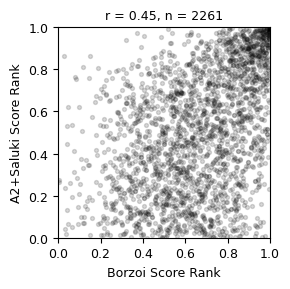

In [7]:
#Compare A2+Saluki and Borzoi ranks

import matplotlib.pyplot as plt
from scipy.stats import spearmanr

filter_query = "min_dist <= 2000"

df_filtered = df_snp.loc[~df_snp['delta_score_aparent2_and_saluki'].isnull()].query(filter_query)

r_val = spearmanr(df_filtered['borzoi_rank'], df_filtered['aparent2_and_saluki_rank'])[0]

f = plt.figure(figsize=(3, 3))

plt.scatter(df_filtered['borzoi_rank'], df_filtered['aparent2_and_saluki_rank'], s=8, color='black', alpha=0.15)

plt.title("r = " + str(round(r_val, 2)) + ", n = " + str(len(df_filtered)), fontsize=9)

plt.xlabel("Borzoi Score Rank", fontsize=9)
plt.ylabel("A2+Saluki Score Rank", fontsize=9)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=9)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=9)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()

plt.show()


In [8]:
#Show statistics for example SNP (after filtering)

df_snp_pos.query("snp == 'chr14_57290084_G_A'")[['snp', 'delta_score_aparent2', 'delta_score_aparent2_and_polyadb', 'delta_score_aparent2_and_saluki', 'delta_score_borzoi', 'delta_score_aparent2_and_saluki_and_borzoi']]


,snp,delta_score_aparent2,delta_score_aparent2_and_polyadb,delta_score_aparent2_and_saluki,delta_score_borzoi,delta_score_aparent2_and_saluki_and_borzoi
170,chr14_57290084_G_A,0.79564,0.037866,0.00413,1.041992,0.954134


In [9]:
#Sort by SNP

df_snp_pos = df_snp_pos.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)


In [10]:
#Calculate distances to aligned-on core hexamer motif (APARENT2 predictions)

df_snp_pos.loc[df_snp_pos['pas'].isnull(), 'rel_snp_pos'] = np.nan
df_snp_neg.loc[df_snp_neg['pas'].isnull(), 'rel_snp_pos'] = np.nan

df_snp_pos['rel_pos'] = df_snp_pos['rel_snp_pos'] - 175 - 30
df_snp_neg['rel_pos'] = df_snp_neg['rel_snp_pos'] - 175 - 30

df_snp_pos['cse_dist'] = np.abs(df_snp_pos['rel_pos'])
df_snp_neg['cse_dist'] = np.abs(df_snp_neg['rel_pos'])

#Calculate distances to aligned-on core hexamer motif (APARENT2+Saluki predictions)

df_snp_pos.loc[df_snp_pos['pas_2'].isnull(), 'rel_snp_pos_2'] = np.nan
df_snp_neg.loc[df_snp_neg['pas_2'].isnull(), 'rel_snp_pos_2'] = np.nan

df_snp_pos['rel_pos_2'] = df_snp_pos['rel_snp_pos_2'] - 175 - 30
df_snp_neg['rel_pos_2'] = df_snp_neg['rel_snp_pos_2'] - 175 - 30

df_snp_pos['cse_dist_2'] = np.abs(df_snp_pos['rel_pos_2'])
df_snp_neg['cse_dist_2'] = np.abs(df_snp_neg['rel_pos_2'])


n pos = 421
n neg = 1840


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


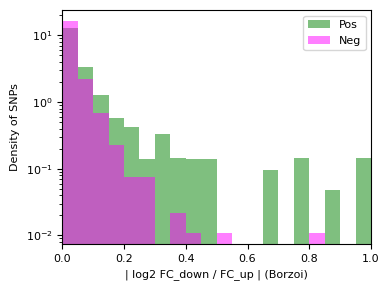

In [11]:
#Plot distribution of SNP effect sizes (for cis-regulatory PAS SNPs only, <= 2000 bp)

import matplotlib.pyplot as plt

filter_query = "min_dist <= 2000"

pos_score = np.clip(np.abs(df_snp_pos.loc[~df_snp_pos['delta_score_aparent2_and_saluki'].isnull()].query(filter_query)['delta_score_borzoi'].values), 0.0, 1.0)
neg_score = np.clip(np.abs(df_snp_neg.loc[~df_snp_neg['delta_score_aparent2_and_saluki'].isnull()].query(filter_query)['delta_score_borzoi'].values), 0.0, 1.0)

print("n pos = " + str(pos_score.shape[0]))
print("n neg = " + str(neg_score.shape[0]))

f = plt.figure(figsize=(4, 3))

plt.hist(pos_score, bins=20, color='green', range=(0.0, 1.0), density=True, log=True, alpha=0.5, label='Pos')
plt.hist(neg_score, bins=20, color='magenta', range=(0.0, 1.0), density=True, log=True, alpha=0.5, label='Neg')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("| log2 FC_down / FC_up | (Borzoi)", fontsize=8)
plt.ylabel("Density of SNPs", fontsize=8)

plt.xlim(0.0, 1.0)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_paqtl_v2_pip90_bench_covr_histo.png", transparent=False, dpi=300)
plt.savefig("borzoi_paqtl_v2_pip90_bench_covr_histo.eps")

plt.show()


n pos = 421
n neg = 1840


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


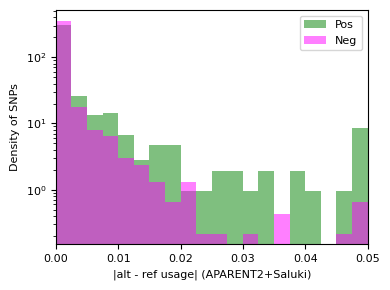

In [12]:
#Plot distribution of SNP effect sizes (for cis-regulatory PAS SNPs only, <= 2000 bp)

import matplotlib.pyplot as plt

filter_query = "min_dist <= 2000"

pos_score = np.clip(np.abs(df_snp_pos.loc[~df_snp_pos['delta_score_aparent2_and_saluki'].isnull()].query(filter_query)['delta_score_aparent2_and_saluki'].values), 0.0, 0.05)
neg_score = np.clip(np.abs(df_snp_neg.loc[~df_snp_neg['delta_score_aparent2_and_saluki'].isnull()].query(filter_query)['delta_score_aparent2_and_saluki'].values), 0.0, 0.05)

print("n pos = " + str(pos_score.shape[0]))
print("n neg = " + str(neg_score.shape[0]))

f = plt.figure(figsize=(4, 3))

plt.hist(pos_score, bins=20, color='green', range=(0.0, 0.05), density=True, log=True, alpha=0.5, label='Pos')
plt.hist(neg_score, bins=20, color='magenta', range=(0.0, 0.05), density=True, log=True, alpha=0.5, label='Neg')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("|alt - ref usage| (APARENT2+Saluki)", fontsize=8)
plt.ylabel("Density of SNPs", fontsize=8)

plt.xlim(0.0, 0.05)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_paqtl_v2_pip90_bench_a2s_histo.png", transparent=False, dpi=300)
plt.savefig("borzoi_paqtl_v2_pip90_bench_a2s_histo.eps")

plt.show()


n pos = 421
n neg = 1840


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


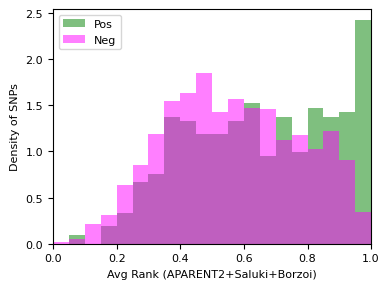

In [13]:
#Plot distribution of SNP effect sizes (for cis-regulatory PAS SNPs only, <= 2000 bp); Average Borzoi+A2+Saluki ranks

import matplotlib.pyplot as plt

filter_query = "min_dist <= 2000"

pos_score = np.clip(np.abs(df_snp_pos.loc[~df_snp_pos['delta_score_aparent2_and_saluki'].isnull()].query(filter_query)['delta_score_aparent2_and_saluki_and_borzoi'].values), 0.0, 1.0)
neg_score = np.clip(np.abs(df_snp_neg.loc[~df_snp_neg['delta_score_aparent2_and_saluki'].isnull()].query(filter_query)['delta_score_aparent2_and_saluki_and_borzoi'].values), 0.0, 1.0)

print("n pos = " + str(pos_score.shape[0]))
print("n neg = " + str(neg_score.shape[0]))

f = plt.figure(figsize=(4, 3))

plt.hist(pos_score, bins=20, color='green', range=(0.0, 1.0), density=True, log=False, alpha=0.5, label='Pos')
plt.hist(neg_score, bins=20, color='magenta', range=(0.0, 1.0), density=True, log=False, alpha=0.5, label='Neg')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("Avg Rank (APARENT2+Saluki+Borzoi)", fontsize=8)
plt.ylabel("Density of SNPs", fontsize=8)

plt.xlim(0.0, 1.0)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_paqtl_v2_pip90_bench_avgrank_histo.png", transparent=False, dpi=300)
plt.savefig("borzoi_paqtl_v2_pip90_bench_avgrank_histo.eps")

plt.show()


In [14]:
#Evaluate SNP classification performance based on scalar effect size predictions, as a function of SNP-PAS distance

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

frac_sample = 0.8
n_shuffles = 100
min_distances = [100, 50]
cse_distances = [100, 50]

#Define models to compare
score_names = ['delta_score_aparent2', 'delta_score_aparent2_and_polyadb', 'delta_score_borzoi']
model_names = ['APARENT2', 'A2+PolyADB', 'Borzoi']
model_colors = ['blue', 'orange', 'red']

cse_dist_suffix = '_2'

auc_mat = np.zeros((len(min_distances) * len(score_names), n_shuffles))
ap_mat = np.zeros((len(min_distances) * len(score_names), n_shuffles))

df_snp_pos['is_causal'] = 1
df_snp_neg['is_causal'] = 0

#Loop over distance thresholds
for dist_ix, [min_dist, cse_dist] in enumerate(zip(min_distances, cse_distances)) :
    
    #Filter dataframe on distance to nearest PAS (and potentially on aligned CSE distance)
    df_snp_pos_filtered = df_snp_pos
    df_snp_neg_filtered = df_snp_neg
    
    filter_query = "min_dist <= " + str(min_dist)
    
    if cse_dist is not None :
        df_snp_pos_filtered = df_snp_pos.loc[~df_snp_pos['cse_dist' + cse_dist_suffix].isnull()]
        df_snp_neg_filtered = df_snp_neg.loc[~df_snp_neg['cse_dist' + cse_dist_suffix].isnull()]
        
        filter_query += " and cse_dist" + cse_dist_suffix + " <= " + str(cse_dist)

    #Select only SNPs within distance threshold
    df_snp_pos_filtered = df_snp_pos_filtered.query(filter_query)
    df_snp_neg_filtered = df_snp_neg_filtered.query(filter_query)
    
    #Filter on non-NaN predictions for all considered models
    for score_name in score_names :
        df_snp_pos_filtered = df_snp_pos_filtered.loc[~df_snp_pos_filtered[score_name].isnull()]
        df_snp_neg_filtered = df_snp_neg_filtered.loc[~df_snp_neg_filtered[score_name].isnull()]

    print("distance <= " + str(min_dist))
    
    shuffle_index_pos = np.arange(len(df_snp_pos_filtered))
    shuffle_index_neg = np.arange(len(df_snp_neg_filtered))

    #Loop over perturbation indices
    for shuffle_ix in range(n_shuffles) :

        np.random.shuffle(shuffle_index_pos)
        np.random.shuffle(shuffle_index_neg)
        
        #Get perturbation sample
        df_snp_pos_shuffled = df_snp_pos_filtered.iloc[shuffle_index_pos].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_filtered.iloc[shuffle_index_neg].copy().reset_index(drop=True)
        
        #Select unique matched IDs
        df_snp_pos_shuffled = df_snp_pos_shuffled.drop_duplicates(subset=['snp'], keep='first').copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.drop_duplicates(subset=['matched_snp'], keep='first').copy().reset_index(drop=True)

        df_snp_pos_shuffled = df_snp_pos_shuffled.loc[df_snp_pos_shuffled['snp'].isin(df_snp_neg_shuffled['matched_snp'])].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.loc[df_snp_neg_shuffled['matched_snp'].isin(df_snp_pos_shuffled['snp'])].copy().reset_index(drop=True)

        if shuffle_ix == 0 :
            print("- n pos = " + str(len(df_snp_pos_shuffled)))
            print("- n neg = " + str(len(df_snp_neg_shuffled)))

        n_min = min(len(df_snp_pos_shuffled), len(df_snp_neg_shuffled))
        n_sample = int(frac_sample * n_min)

        if shuffle_ix == 0 :
            print("- n sample = " + str(n_sample))

        df_snp = pd.concat([df_snp_pos_shuffled.iloc[:n_sample], df_snp_neg_shuffled.iloc[:n_sample]])

        #Loop over models
        for model_ix, score_name, in enumerate(score_names) :
        
            score = np.abs(np.array(df_snp[score_name].values))
            distance = -np.abs(np.array(df_snp['min_dist'].values))
            label = np.array(df_snp['is_causal'].values)

            #AUC score
            auc = roc_auc_score(label, score)
            
            #Precision-recall scores
            ap = average_precision_score(label, score)

            auc_mat[dist_ix * len(model_names) + model_ix, shuffle_ix] = auc
            ap_mat[dist_ix * len(model_names) + model_ix, shuffle_ix] = ap


distance <= 100
- n pos = 155
- n neg = 155
- n sample = 124
distance <= 50
- n pos = 101
- n neg = 101
- n sample = 80


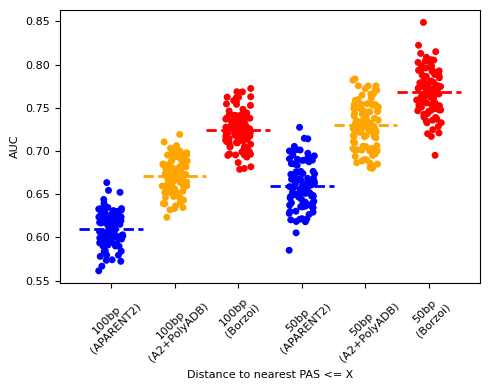

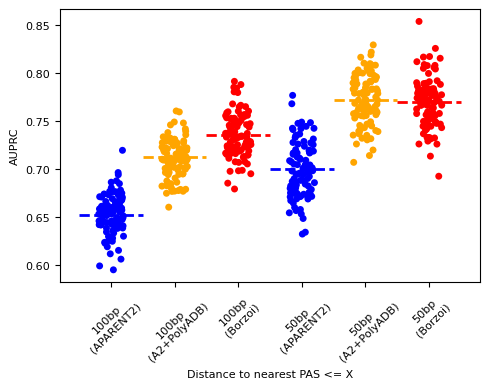

In [15]:
import seaborn as sns

#Visualize AUC distributions
f = plt.figure(figsize=(5, 4))

x_labels = []
colors = []
for min_dist in min_distances :
    for model_name, model_color in zip(model_names, model_colors) :
        x_labels.append(str(min_dist) + 'bp\n(' + model_name + ')')
        colors.append(model_color)

sns.stripplot(data=[auc_mat[i, :] for i in range(auc_mat.shape[0])], jitter=0.2, palette=colors)

for i in range(auc_mat.shape[0]) :
    plt.plot([i-0.5, i+0.5], [np.mean(auc_mat[i, :]), np.mean(auc_mat[i, :])], color=colors[i], linewidth=2, linestyle='--')

plt.xticks(np.arange(len(model_names) * len(min_distances)), x_labels, fontsize=8, rotation=45)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest PAS <= X", fontsize=8)
plt.ylabel("AUC", fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_paqtl_v2_pip90_vs_aparent_short_distance_auc.png", transparent=False, dpi=300)
plt.savefig("borzoi_paqtl_v2_pip90_vs_aparent_short_distance_auc.eps")

plt.show()

#Visualize AP distributions
f = plt.figure(figsize=(5, 4))

x_labels = []
colors = []
for min_dist in min_distances :
    for model_name, model_color in zip(model_names, model_colors) :
        x_labels.append(str(min_dist) + 'bp\n(' + model_name + ')')
        colors.append(model_color)

sns.stripplot(data=[ap_mat[i, :] for i in range(auc_mat.shape[0])], jitter=0.2, palette=colors)

for i in range(ap_mat.shape[0]) :
    plt.plot([i-0.5, i+0.5], [np.mean(ap_mat[i, :]), np.mean(ap_mat[i, :])], color=colors[i], linewidth=2, linestyle='--')

plt.xticks(np.arange(len(model_names) * len(min_distances)), x_labels, fontsize=8, rotation=45)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest PAS <= X", fontsize=8)
plt.ylabel("AUPRC", fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_paqtl_v2_pip90_vs_aparent_short_distance_ap.png", transparent=False, dpi=300)
plt.savefig("borzoi_paqtl_v2_pip90_vs_aparent_short_distance_ap.eps")

plt.show()


In [11]:
#Evaluate SNP classification performance based on scalar effect size predictions, as a function of SNP-PAS distance

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

frac_sample = 0.8
n_shuffles = 100
min_distances = [2000, 500, 300, 200, 100, 50]
cse_distances = [None, None, None, None, 100, 50]

#Define models to compare
score_names = ['delta_score_aparent2_and_saluki', 'delta_score_borzoi', 'delta_score_aparent2_and_saluki_and_borzoi']
model_names = ['A2+Saluki', 'Borzoi', 'A2+Sal+Borzoi']
model_colors = ['green', 'red', 'violet']

cse_dist_suffix = '_2'

auc_mat = np.zeros((len(min_distances) * len(score_names), n_shuffles))
ap_mat = np.zeros((len(min_distances) * len(score_names), n_shuffles))

df_snp_pos['is_causal'] = 1
df_snp_neg['is_causal'] = 0

#Loop over distance thresholds
for dist_ix, [min_dist, cse_dist] in enumerate(zip(min_distances, cse_distances)) :
    
    #Filter dataframe on distance to nearest PAS (and potentially on aligned CSE distance)
    df_snp_pos_filtered = df_snp_pos
    df_snp_neg_filtered = df_snp_neg
    
    filter_query = "min_dist <= " + str(min_dist)
    
    if cse_dist is not None :
        df_snp_pos_filtered = df_snp_pos.loc[~df_snp_pos['cse_dist' + cse_dist_suffix].isnull()]
        df_snp_neg_filtered = df_snp_neg.loc[~df_snp_neg['cse_dist' + cse_dist_suffix].isnull()]
        
        filter_query += " and cse_dist" + cse_dist_suffix + " <= " + str(cse_dist)

    #Select only SNPs within distance threshold
    df_snp_pos_filtered = df_snp_pos_filtered.query(filter_query)
    df_snp_neg_filtered = df_snp_neg_filtered.query(filter_query)
    
    #Filter on non-NaN predictions for all considered models
    for score_name in score_names :
        df_snp_pos_filtered = df_snp_pos_filtered.loc[~df_snp_pos_filtered[score_name].isnull()]
        df_snp_neg_filtered = df_snp_neg_filtered.loc[~df_snp_neg_filtered[score_name].isnull()]

    print("distance <= " + str(min_dist))
    
    shuffle_index_pos = np.arange(len(df_snp_pos_filtered))
    shuffle_index_neg = np.arange(len(df_snp_neg_filtered))

    #Loop over perturbation indices
    for shuffle_ix in range(n_shuffles) :

        np.random.shuffle(shuffle_index_pos)
        np.random.shuffle(shuffle_index_neg)
        
        #Get perturbation sample
        df_snp_pos_shuffled = df_snp_pos_filtered.iloc[shuffle_index_pos].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_filtered.iloc[shuffle_index_neg].copy().reset_index(drop=True)
        
        #Select unique matched IDs
        df_snp_pos_shuffled = df_snp_pos_shuffled.drop_duplicates(subset=['snp'], keep='first').copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.drop_duplicates(subset=['matched_snp'], keep='first').copy().reset_index(drop=True)

        df_snp_pos_shuffled = df_snp_pos_shuffled.loc[df_snp_pos_shuffled['snp'].isin(df_snp_neg_shuffled['matched_snp'])].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.loc[df_snp_neg_shuffled['matched_snp'].isin(df_snp_pos_shuffled['snp'])].copy().reset_index(drop=True)

        if shuffle_ix == 0 :
            print("- n pos = " + str(len(df_snp_pos_shuffled)))
            print("- n neg = " + str(len(df_snp_neg_shuffled)))

        n_min = min(len(df_snp_pos_shuffled), len(df_snp_neg_shuffled))
        n_sample = int(frac_sample * n_min)

        if shuffle_ix == 0 :
            print("- n sample = " + str(n_sample))

        df_snp = pd.concat([df_snp_pos_shuffled.iloc[:n_sample], df_snp_neg_shuffled.iloc[:n_sample]])

        #Loop over models
        for model_ix, score_name, in enumerate(score_names) :
        
            score = np.abs(np.array(df_snp[score_name].values))
            distance = -np.abs(np.array(df_snp['min_dist'].values))
            label = np.array(df_snp['is_causal'].values)

            #AUC score
            auc = roc_auc_score(label, score)
            
            #Precision-recall scores
            ap = average_precision_score(label, score)
            ap_baseline = average_precision_score(label, distance)
            apr = ap / ap_baseline

            auc_mat[dist_ix * len(model_names) + model_ix, shuffle_ix] = auc
            ap_mat[dist_ix * len(model_names) + model_ix, shuffle_ix] = ap


distance <= 2000
- n pos = 333
- n neg = 333
- n sample = 266
distance <= 500
- n pos = 290
- n neg = 290
- n sample = 232
distance <= 300
- n pos = 267
- n neg = 267
- n sample = 213
distance <= 200
- n pos = 223
- n neg = 223
- n sample = 178
distance <= 100
- n pos = 155
- n neg = 155
- n sample = 124
distance <= 50
- n pos = 101
- n neg = 101
- n sample = 80


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


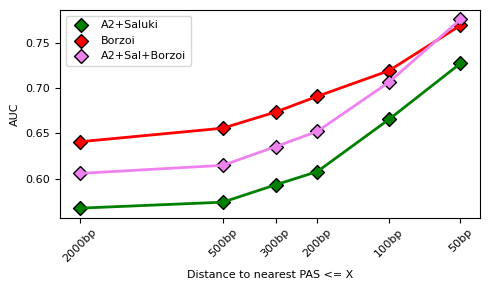

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


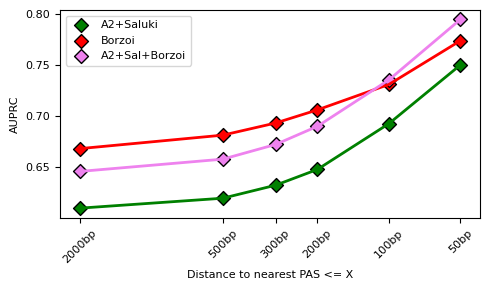

In [23]:
import seaborn as sns

#Plot AUC trajectories

auc_mat_r = np.reshape(auc_mat, (len(min_distances), len(model_names), n_shuffles))

f = plt.figure(figsize=(5, 3))

for j in range(auc_mat_r.shape[1]) :
    plt.scatter(np.log10(np.array(min_distances)), np.mean(auc_mat_r[:, j, :], axis=-1), s=50, marker='D', color=model_colors[j], edgecolor='black', linewidth=1, label=model_names[j])
    plt.plot(np.log10(np.array(min_distances)), np.mean(auc_mat_r[:, j, :], axis=-1), color=model_colors[j], linewidth=2)

plt.legend(fontsize=8)

plt.xticks(np.log10(min_distances), [str(min_distances[k]) + "bp" for k in range(len(min_distances))], fontsize=8, rotation=45)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest PAS <= X", fontsize=8)
plt.ylabel("AUC", fontsize=8)

plt.xlim(np.max(np.log10(min_distances))+0.025*np.max(np.log10(min_distances)), np.min(np.log10(min_distances))-0.025*np.max(np.log10(min_distances)))

plt.tight_layout()

plt.savefig("borzoi_paqtl_v2_pip90_vs_a2s_short_traj_auc.png", transparent=False, dpi=300)
plt.savefig("borzoi_paqtl_v2_pip90_vs_a2s_short_traj_auc.eps")

plt.show()

#Plot APR trajectories

ap_mat_r = np.reshape(ap_mat, (len(min_distances), len(model_names), n_shuffles))

f = plt.figure(figsize=(5, 3))

for j in range(auc_mat_r.shape[1]) :
    plt.scatter(np.log10(np.array(min_distances)), np.mean(ap_mat_r[:, j, :], axis=-1), s=50, marker='D', color=model_colors[j], edgecolor='black', linewidth=1, label=model_names[j])
    plt.plot(np.log10(np.array(min_distances)), np.mean(ap_mat_r[:, j, :], axis=-1), color=model_colors[j], linewidth=2)

plt.legend(fontsize=8)

plt.xticks(np.log10(min_distances), [str(min_distances[k]) + "bp" for k in range(len(min_distances))], fontsize=8, rotation=45)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest PAS <= X", fontsize=8)
plt.ylabel("AUPRC", fontsize=8)

plt.xlim(np.max(np.log10(min_distances))+0.025*np.max(np.log10(min_distances)), np.min(np.log10(min_distances))-0.025*np.max(np.log10(min_distances)))

plt.tight_layout()

plt.savefig("borzoi_paqtl_v2_pip90_vs_a2s_short_traj_ap.png", transparent=False, dpi=300)
plt.savefig("borzoi_paqtl_v2_pip90_vs_a2s_short_traj_ap.eps")

plt.show()
